# Predicting most Efficient Interventions for Life Span Increase
#### Data Literacy at University of Tübingen, Winter 2023/24

---
&copy; Daniel Flat, Jackson Harmon, Eric Nazarenus, Aline Bittler 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

Template by Philipp Hennig, 2023. [CC BY-SA 4.0](https://creativecommons.org/licenses/by-sa/4.0/)

In [79]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dataclasses import dataclass
from scipy.optimize import curve_fit


In [80]:
# Group Constants
MALE = 'male'
FEMALE = 'female'
SEX_CATEGORIES = [MALE, FEMALE]

# Intervention Constants
CONTROL_GROUP = 'None'
ALL_GROUP = 'All'
ONE_REMOVED_PREFIX = 'no_'

# Dataset Contsants
DATASET_DIRECTORY = os.path.join('..', 'dat', 'RMR_data')

# Graphing constants
COLOR_MAP = ["#ADD8E6", "#008000", "#FFD700", "#800080", "#FF7F50", "#40E0D0", "#708090", "#FF8C00", "#FF00FF", "#008080"]

In [81]:
dataset_paths = os.listdir(DATASET_DIRECTORY)

def convert_filename_to_key(filename, category):
    category_removed = filename[len(category) + 1:]
    return os.path.splitext(category_removed)[0]

def create_dataset_mapping(dataset_directory, categories):
    dataset_mappings = {}
    
    for category in categories:
        category_path = {} 
        for path in dataset_paths:
            full_path = os.path.join(dataset_directory, path)
    
            if category == path[:len(category)]:
                key = convert_filename_to_key(path, category)
                category_path[key] = full_path
        dataset_mappings[category] = category_path
    
    return dataset_mappings

In [82]:
def is_one_removed_intervention(key):
    if len(key) < 3:
        return False

    return key[:len(ONE_REMOVED_PREFIX)] == ONE_REMOVED_PREFIX

def extract_single_interventions(dataset_mapping: dict):
    single_interventions = []
    for key in dataset_mapping.keys():
        if key == ALL_GROUP:
            continue
        elif key == CONTROL_GROUP:
            continue
        elif is_one_removed_intervention(key):
            continue
        else:
            single_interventions.append(key)
    
    return single_interventions

def create_one_removed_key(key: str, intervention_list: []) -> []:
    removed_key = key[len(ONE_REMOVED_PREFIX):]

    removed_intervention_list = []
    for intervention in intervention_list:
        if intervention != removed_key:
            removed_intervention_list.append(intervention)

    return removed_intervention_list

def create_intervention_list_from_group(key: str, intervention_list: []):
    new_intervention_list = None
    
    if key == ALL_GROUP:
        new_intervention_list = intervention_list
    elif key == CONTROL_GROUP:
        new_intervention_list = []
    elif is_one_removed_intervention(key):
        new_intervention_list = create_one_removed_key(key, intervention_list)
    else:
        new_intervention_list = [key]

    return ','.join(new_intervention_list)

In [83]:
def load_csv(path):
    return pd.read_csv(
                        path,
                        skiprows=0,
                        sep=',',
                        engine='python',
                        decimal='.',
                        dtype={'x': 'float64', 'y': 'float64'}
            )


def create_dataset_by_category(category_path: dict, single_interventions: []):
    datasets = {}
    for key, path in category_path.items():
        new_key = create_intervention_list_from_group(key, single_interventions)
        datasets[new_key] = load_csv(path)
    return datasets

dataset_mapping = create_dataset_mapping(DATASET_DIRECTORY, SEX_CATEGORIES)
female_dataset_paths = dataset_mapping[FEMALE]
female_single_interventions = extract_single_interventions(female_dataset_paths)

female_dataset = create_dataset_by_category(female_dataset_paths, female_single_interventions)

In [84]:
def gompertz(x, alpha, beta):
    return alpha * np.exp(beta * x)

@dataclass
class GompertzParameters:
    alpha: np.float64
    beta: np.float64

    @staticmethod
    def from_sequence(seq):
        return GompertzParameters(alpha=seq[0], beta=seq[1])

    def to_tuple(self):
        return (self.alpha, self.beta)

    def __str__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'

    def __repr__(self) -> str:
        return f'(alpha={self.alpha:.4f}, beta={self.beta:.4f})'


def fit_gompertz_model(initial_parameters: GompertzParameters,
                       ages: pd.DataFrame,
                       mortality_rate: pd.DataFrame,
                       max_fit_iterations: int = 2_500) -> GompertzParameters:
    p0 = initial_parameters.to_tuple()
    predicted_parameters, covariance = curve_fit(gompertz, ages, mortality_rate, p0=p0, maxfev=max_fit_iterations)
    return GompertzParameters.from_sequence(predicted_parameters)

test_dataset = female_dataset['HSCs']
ages = np.array(test_dataset.x) / 365 # ages in years
mortality_rate = np.array(1 - test_dataset.y)

initial_parameters = GompertzParameters(alpha=0.1, beta=0.085)
predicted_parameters = fit_gompertz_model(initial_parameters, ages, mortality_rate)
predicted_mortality = gompertz(ages, predicted_parameters.alpha, predicted_parameters.beta)

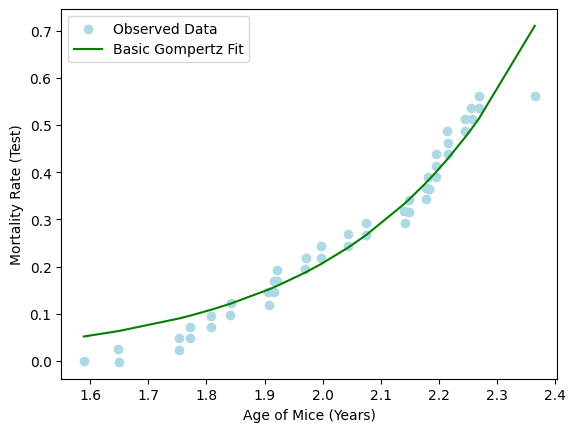

In [85]:
def plot_fitted_gompertz_curve(ages, mortality_rate, predicted_mortality_rate, title: str) -> None:
    plt.scatter(ages, mortality_rate, label='Observed Data', color=COLOR_MAP[0])
    plt.plot(ages, predicted_mortality, label='Basic Gompertz Fit', color=COLOR_MAP[1])
    plt.xlabel('Age of Mice (Years)')
    plt.ylabel(f'Mortality Rate ({title})')
    plt.legend()
    plt.show()

plot_fitted_gompertz_curve(ages, mortality_rate, predicted_mortality, 'Test')